In [12]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.deprecated.doc2vec import LabeledSentence
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics
#from sklearn.grid_search import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.multiclass import unique_labels

from collections import Counter
import matplotlib.pyplot as plt
import string
import re
import random
import glob
import itertools

import json

np.random.seed(1234)
random.seed(1234)

porter = PorterStemmer()
punctuation_dictionary = {s:None for s in list(string.punctuation)}
punctuation_dictionary["-"] = "_"

punctuation_translator = str.maketrans(punctuation_dictionary)

def text_cleaner(text, punctuation_translator, stemmer):
    text = "".join(re.split('xa0',text))
    text = str(text).translate(punctuation_translator)
    text = text.lower()
    text = porter.stem(text)
    return(text)

## Load Speech & Clean

In [42]:
SubSpeech = pd.read_csv('SubSpeech_coded_cleaned.csv')
SubSpeech.tail()

,Candidate,Chanel,City,Content,Date,Day,Description,Month,Speech_index,State,SubContent,Subject,Subspeech_index,Title,Type,URL,Year,Pop
17448,John F. Kennedy,STUMP,PHOENIX,"Ladies and gentlemen, I just hate to think--wo...",11/03,3.0,AIRPORT,11.0,Speech5234,ARIZONA,"['Ladies and gentlemen, I just hate to think--...",-999,Speech5234_0:8,NaN,SPEECH,NaN,1960,NaN
17449,John F. Kennedy,STUMP,PHOENIX,"My friend and colleague in the House, whom I a...",11/03,3.0,WESTWARD,11.0,Speech5235,ARIZONA,"[""My friend and colleague in the House, whom I...",-999,Speech5235_0:5,NaN,SPEECH,NaN,1960,NaN
17450,John F. Kennedy,STUMP,PHOENIX,"Congressman Udall, my friend and colleague fro...",11/03,3.0,STREET,11.0,Speech5236,ARIZONA,"['Congressman Udall, my friend and colleague f...",NATURAL,Speech5236_0:18,NaN,SPEECH,NaN,1960,NaN
17451,John F. Kennedy,STUMP,ALBUQUERQUE,"Mr. Chairman, Governor Burroughs, Senator Chav...",11/03,3.0,-999,11.0,Speech5237,NEW,"['Mr. Chairman, Governor Burroughs, Senator Ch...","CONGRESS,",Speech5237_0:17,NaN,SPEECH,NaN,1960,NaN
17452,John F. Kennedy,STUMP,AMARILLO,Lyndon; Ralph Yarborough; Mr. Mayor; Senator A...,11/03,3.0,AIRPORT,11.0,Speech5238,TEXAS,['Lyndon; Ralph Yarborough; Mr. Mayor; Senator...,"ECONOMY--GENERAL,",Speech5238_0:15,NaN,SPEECH,NaN,1960,NaN


In [43]:
len(SubSpeech.Speech_index.unique()), len(SubSpeech.Subspeech_index)

(4363, 17453)

In [44]:
len(SubSpeech[SubSpeech.Pop.isin(['accept','reject'])].Speech_index.unique())

65

In [45]:
len(SubSpeech[SubSpeech.Pop.isin(['accept','reject'])].Subspeech_index.unique())

419

In [46]:
SubSpeech.Pop.value_counts()

reject    357
accept     62
Name: Pop, dtype: int64

In [11]:
62/419

0.14797136038186157

In [47]:
SubSpeech["clean_text"] = SubSpeech["SubContent"].apply(lambda x: text_cleaner(x, punctuation_translator, porter))

In [6]:
#SubSpeech.head()

In [48]:
phrases1 = Phrases(map(lambda x: x.split(), SubSpeech["clean_text"].tolist()))
phrases2 = Phrases(phrases1[map(lambda x: x.split(), SubSpeech["clean_text"].tolist())])
SubSpeech["phrased_text"] = SubSpeech["clean_text"].apply(lambda x: " ".join(phrases2[phrases1[x.split()]]))

## Doc2Vev Model

In [49]:
docs = list(zip(SubSpeech["phrased_text"].tolist(), SubSpeech["Subspeech_index"].tolist()))


## Define an iterator to feed documents and tags to Doc2Vec
class Sentences(object):
  def __init__(self, docs):
    self.docs = docs
  def __iter__(self):
    for doc in self.docs:
      yield TaggedDocument(words=str(doc[0]).split(), tags=[doc[1]])

## Train and save models
model = Doc2Vec(Sentences(docs), vector_size=150, window=10, min_count=5, negative=10, epochs=20, dm=0, dbow_words=1)

In [37]:
#model.wv.save_word2vec_format("doc2vec_wordvecs.txt", binary=False)

In [50]:
model.save("doc2vec_wordvecs.model")

In [51]:
model.wv.most_similar('democracy')

[('freedom', 0.619663655757904),
 ('democraci', 0.5839061737060547),
 ('genuine_believers', 0.5610077977180481),
 ('export_terror_they', 0.558754563331604),
 ('democracies', 0.5499882698059082),
 ('modernity', 0.5475199222564697),
 ('communism', 0.5471711158752441),
 ('miskito_indians_abuse', 0.5424227714538574),
 ('republic', 0.5357458591461182),
 ('sandinistas_immediately_began', 0.531105637550354)]

In [57]:
#Most similar phrase to populist doc
populist_index = list(set(SubSpeech.loc[SubSpeech['Pop'] == "accept", "Subspeech_index"].tolist()))
print(len(populist_index))
i = 13

value = SubSpeech.loc[SubSpeech['Subspeech_index']==populist_index[i]]["Content"].tolist()
print(value)
model.wv.most_similar([model.docvecs[populist_index[i]]])

62
['\nThis is amazing. What a great place. Thank you very much. We have thousands of people outside trying to get in. But we should start. Do we agree? [applause]\nWe should start. So they\'ll come in. They\'ll come in.\nFirst of all I want to thank you. Special, special place. It\'s a special place with incredible people. In one day, do you believe this? One day we are going to win the great state of North Carolina... [applause]\nAnd we are going to win back the White House. [applause]\nThis election will decide whether we are ruled by a corrupt political class. You\'re seeing what\'s happening. Everybody\'s watching. Or whether we are ruled by the people. We\'re going to be ruled by the people, folks. [applause]\nThat is going to be the choice. A failed political establishment has delivered nothing but poverty, nothing but problems, nothing but losses. Nothing but losses. We don\'t win anymore as a country. We\'re going to start winning again. [applause]\nThey get rich by making Ame

[('crooked_hillary', 0.5500898361206055),
 ('buzzing', 0.48584043979644775),
 ('crooked_hillary_clinton', 0.4827480912208557),
 ('pretty_amazing', 0.4824979305267334),
 ('monei', 0.4736645519733429),
 ('lock_her_up_lock', 0.47317051887512207),
 ('booing', 0.46610695123672485),
 ('errand', 0.46151503920555115),
 ('iran_deal', 0.46104520559310913),
 ('totally_dishonest', 0.45536530017852783)]

## Classification

In [20]:
SubSpeech = pd.read_csv('SubSpeech_coded_cleaned.csv')

In [25]:
#SubSpeech.head()

In [14]:
model = Word2Vec.load("doc2vec_wordvecs.model")

In [59]:
SubSpeech.Pop.replace('accept',1, inplace=True)

In [60]:
SubSpeech.Pop.replace('reject',0, inplace=True)

In [61]:
SubSpeech.Pop.value_counts()

0.0    357
1.0     62
Name: Pop, dtype: int64

In [62]:
labelled_data = SubSpeech.loc[SubSpeech['Pop'].isin([0,1])][["Subspeech_index","Pop"]]
labelled_data = labelled_data.groupby(["Subspeech_index"]).mean()
print(labelled_data.head())
print(labelled_data.shape)

X = np.asarray([model.docvecs[i] for i in labelled_data.index.tolist()])
Y = np.asarray(labelled_data['Pop'].tolist(), dtype="int")

# ## Get the words most closely associated with all of the "populist" articles
# for k, v in model.most_similar(model.docvecs[populist_indices], topn=50):
#   print(k) 
#kf = KFold(n_splits=5)

print(X.shape)
print(Y)

                    Pop
Subspeech_index        
Speech1025_0:10     0.0
Speech1025_100:110  0.0
Speech1025_10:20    0.0
Speech1025_110:120  0.0
Speech1025_120:130  0.0
(419, 1)
(419, 150)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AUC: 0.9367588932806323
Accuracy: 0.9
Mean AUC: 0.9367588932806323
Mean Accuracy: 0.9


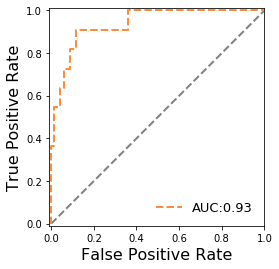

In [233]:
auc_scores_d2v = []
accuracy_scores_d2v = []

np.random.seed(234) 
random.seed(234)

plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['savefig.transparent'] = 'false'

plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.axes().set_aspect('equal')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
#plt.title('ROC curve', fontsize=16)
for i in range(1):
    ## Create a test and train set
    test_size = 80
    test_set = random.sample(range(0,len(Y)), test_size)
    train_set = list(set(list(range(0,len(Y)))) - set(test_set))
    ## Initialize a random forest classifier
    gbc = RandomForestClassifier(n_estimators=5000, max_depth=10, random_state=0, class_weight="balanced")
  # gbc = GradientBoostingClassifier(loss="deviance",
  #   learning_rate=0.1,
  #   n_estimators=20000,
  #   subsample=1.0,
  #   min_samples_split=2,
  #   min_samples_leaf=1,
  #   max_depth=4,
  #   init=None,
  #   random_state=None,
  #   max_features=None,
  #   verbose=0)
    gbc = CalibratedClassifierCV(gbc, cv=3, method="sigmoid")
    #gbc = CalibratedClassifierCV(gbc, cv=2, method="isotonic")
    ## Fit the model to the training set
    gbc.fit(X[np.asarray(train_set, dtype="int")], Y[np.asarray(train_set, dtype="int")])
    ## Predict out-of-sample on the test set and compute AUC
    preds = gbc.predict_proba(X[np.asarray(test_set, dtype="int")])
    fpr_d2v, tpr_d2v, thresholds_d2v = metrics.roc_curve(Y[np.asarray(test_set, dtype="int")], preds[:,1], pos_label=1)
    auc_scores_d2v = auc_scores_d2v + [metrics.auc(fpr_d2v, tpr_d2v)]
    plt.plot(fpr_d2v, tpr_d2v, lw=2, linestyle='--', label="AUC:" + str(metrics.auc(fpr_d2v, tpr_d2v))[0:4],color='#fd8d3c')
    print("AUC: "+str(metrics.auc(fpr_d2v, tpr_d2v)))
    accuracy_d2v = metrics.accuracy_score(Y[np.asarray(test_set, dtype="int")], gbc.predict(X[np.asarray(test_set, dtype="int")]), normalize=True)
    accuracy_scores_d2v = accuracy_scores_d2v + [accuracy_d2v]
    print("Accuracy: " + str(accuracy_d2v))
leg = plt.legend(framealpha = 0,loc='lower right', fontsize=13)
for text in leg.get_texts():
    plt.setp(text, color = 'black')
plt.savefig('images/d2v_rocs.png')
# vocab = model.wv.vocab.keys()
# vectors = [model[v] for v in vocab]
# vectors = np.asarray(vectors)

# word_preds = gbc.predict_proba(vectors)
# word_scores = dict(zip(vocab, word_preds[:,1].tolist()))
# sorted_keys = sorted(word_scores, key=word_scores.get, reverse=True)
# for r in sorted_keys[0:100]:
#     print(str(r))
print("Mean AUC: " + str(np.mean(auc_scores_d2v)))
print("Mean Accuracy: " + str(np.mean(accuracy_scores_d2v)))

In [228]:
predicted = gbc.predict(X[np.asarray(test_set, dtype="int")])
confusion = confusion_matrix(Y[np.asarray(test_set, dtype="int")], predicted)
print(confusion)

[[69  0]
 [ 8  3]]


In [75]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[69  0]
 [ 8  3]]


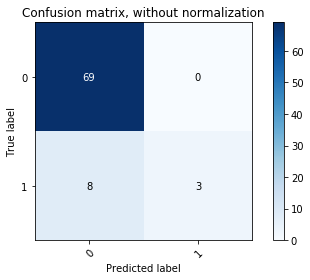

In [76]:
plot_confusion_matrix(Y[np.asarray(test_set, dtype="int")], predicted, 
                      title='Confusion matrix, without normalization')

In [234]:
scores = gbc.predict_proba(np.asarray([model.docvecs[a] for a in SubSpeech["Subspeech_index"]]))
predictions = gbc.predict(np.asarray([model.docvecs[a] for a in SubSpeech["Subspeech_index"]]))

In [235]:
SubSpeech["Pop_class"] = predictions.tolist()
SubSpeech["Pop_prob"] = scores[:,1].tolist()

In [236]:
SubSpeech["Pop_prob"].describe()

count    17453.000000
mean         0.122770
std          0.099268
min          0.022972
25%          0.062613
50%          0.090324
75%          0.143656
max          0.932032
Name: Pop_prob, dtype: float64

In [77]:
#SubSpeech.sort_values(by=['Pop_prob']).tail()

In [239]:
SubSpeech["Pop_class"] = [1 if x>=0.35 else 0 for x in SubSpeech["Pop_prob"]]

In [240]:
np.mean(SubSpeech["Pop_class"])

0.03999312439122214

Confusion matrix, without normalization
[[354   3]
 [  5  57]]


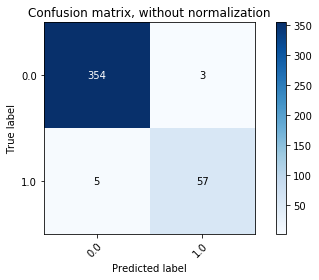

In [241]:
plot_confusion_matrix(SubSpeech.loc[SubSpeech['Pop'].isin([0,1])]["Pop"], 
                      SubSpeech.loc[SubSpeech['Pop'].isin([0,1])]["Pop_class"])

In [242]:
test_proba = gbc.predict_proba(X[np.asarray(test_set, dtype="int")])[:,1]
test_class = [1 if x>=0.35 else 0 for x in test_proba]

Confusion matrix, without normalization
[[67  2]
 [ 5  6]]


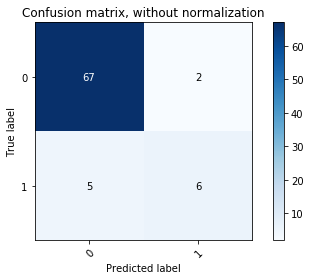

In [243]:
plot_confusion_matrix(Y[np.asarray(test_set, dtype="int")], test_class, 
                      title='Confusion matrix, without normalization')

In [68]:
SubSpeech.to_csv('SubSpeech_predicted_update.csv', index=False)

In [244]:
SubSpeech.to_csv('SubSpeech_predicted_update_new.csv', index=False)

## Example for paper

In [122]:
outsample = SubSpeech[SubSpeech.Pop.isna()]

In [124]:
outsample[outsample.Candidate != 'Donald J. Trump'].sort_values('Pop_prob', ascending = False).head(10)

,Candidate,Chanel,City,Content,Date,Day,Description,Month,Speech_index,State,...,Subspeech_index,Title,Type,URL,Year,Pop,clean_text,phrased_text,Pop_class,Pop_prob
5256,Barack Obama,NaN,NaN,\nWe meet here at a time of great uncertainty ...,"\nSeptember 28, 2008",28.0,NaN,September,Speech924,NaN,...,Speech924_10:20,"\nRemarks in Detroit, Michigan\n",Campaign Documents,/documents/remarks-detroit-michigan,2008,NaN,third i said that we cannot and will not simpl...,third i said that we cannot and will not simpl...,1,0.716134
1627,Bernie Sanders,NaN,NaN,\nAUDIENCE: Bernie! Bernie! Bernie! Bernie!\nS...,"\nJanuary 26, 2016",26.0,NaN,January,Speech202,NaN,...,Speech202_80:99,\nRemarks in a Meeting with Steelworkers in De...,Campaign Documents,/documents/remarks-meeting-with-steelworkers-d...,2016,NaN,and we are going to pass a medicare for all si...,and we are going to pass a medicare for all si...,1,0.649169
7148,Hillary Clinton,NaN,NaN,\nThank you. Thank you. Thank you so much. Tha...,"\nNovember 10, 2007",10.0,NaN,November,Speech1340,NaN,...,Speech1340_30:46,\nRemarks at the Iowa Jefferson-Jackson Dinner...,Campaign Documents,/documents/remarks-the-iowa-jefferson-jackson-...,2007,NaN,and we believe in a department of labor that i...,and we believe in a department of labor that i...,1,0.623208
6153,Barack Obama,NaN,NaN,\nIt's great to be here in Missouri with my go...,"\nMay 13, 2008",13.0,NaN,May,Speech1124,NaN,...,Speech1124_10:24,"\nRemarks in Cape Girardeau, Missouri\n",Campaign Documents,/documents/remarks-cape-girardeau-missouri,2008,NaN,four more years of a president who supports pr...,four_more years of a president who supports pr...,1,0.612297
1511,Bernie Sanders,NaN,NaN,"\nMATTHEWS: Well, I didn't know I was going to...","\nFebruary 25, 2016",25.0,NaN,February,Speech179,NaN,...,Speech179_130:140,"\nRemarks with Chris Matthews at the MSNBC ""Ha...",Campaign Documents,/documents/remarks-with-chris-matthews-the-msn...,2016,NaN,and you know why because wall street and corpo...,and you know why because wall_street and corpo...,1,0.610532
6336,Barack Obama,NaN,NaN,\nGood afternoon. I know I kept a lot of you g...,"\nApril 14, 2008",14.0,NaN,April,Speech1167,NaN,...,Speech1167_20:34,\nRemarks at the Associated Press Annual Lunch...,Campaign Documents,/documents/remarks-the-associated-press-annual...,2008,NaN,well im making a different bet im betting on t...,well im making a different bet im_betting_on t...,1,0.592607
14083,Walter F. Mondale,STUMP,CHICAGO,Let's hear it for Eddie Vdrolyak. Let's hear i...,10/30,30.0,MEDINAH,10.0,Speech3959,ILLINOIS,...,Speech3959_30:40,NaN,SPEECH,NaN,1984,NaN,ti want an america where the president defends...,ti want an america where the president defends...,1,0.589449
5263,Barack Obama,NaN,NaN,\nWe meet here at a time of great uncertainty ...,"\nSeptember 27, 2008",27.0,NaN,September,Speech926,NaN,...,Speech926_10:20,"\nRemarks in Greensboro, North Carolina\n",Campaign Documents,/documents/remarks-greensboro-north-carolina-1,2008,NaN,you see i think senator mccain just doesnt get...,you see i think senator_mccain just doesnt get...,1,0.588102
2071,Bernie Sanders,NaN,NaN,"\nBrothers and sisters, thank you for inviting...","\nAugust 18, 2015",18.0,NaN,August,Speech263,NaN,...,Speech263_30:40,\nRemarks at the Nevada State AFL-CIO Constitu...,Campaign Documents,/documents/remarks-the-nevada-state-afl-cio-co...,2015,NaN,why what do the koch brothers want let me tell...,why what do the koch_brothers want let_me_tell...,1,0.579591
7758,Barack Obama,NaN,NaN,\nIt has now been a little over four months si...,"\nJune 19, 2007",19.0,NaN,June,Speech1462,NaN,...,Speech1462_20:30,"\nRemarks in Washington, DC at Take Back Ameri...",Campaign Documents,/documents/remarks-washington-dc-take-back-ame...,2007,NaN,we believe that we rise or fall as one people ...,we believe that we rise or fall as one people ...,1,0.576269


In [117]:
outsample.clean_text[0]

' president donald trump thank you thank you wow this is great look snow i didnt know what was going on this is—i said you sure this is indoor that beautiful snow looks so real thats the end of my suit thats the end of the hair for tonight thats ok i love mississippi and i love being with you in mississippi thank you very much thank you applause thank you its a beautiful place this is a big—this is a big beautiful arena and they have thousands of people outside and this place is packed theres nothing like a trump rally do we agree nothing like a trump rally applause im thrilled to be here with the great people of mississippi you are the men and women that make america truly great and thank you thank you applause thank you tomorrow we need the people of mississippi to go to the polls and elect cindy hyde_smith so that we can continue doing what were doing which is frankly unprecedented whats happening is unprecedented look whats the simple two words its called america first america firs

In [245]:
outsample.URL[5256]

'/documents/remarks-detroit-michigan'

## Blind Test (prodigy)

In [128]:
SubSpeech_predicted = pd.read_csv('SubSpeech_predicted.csv')

In [128]:
#SubSpeech_predicted.head()

In [129]:
virgintext = SubSpeech.loc[-SubSpeech['Pop'].isin([0,1])]

In [130]:
virgintext = virgintext[virgintext.Candidate != 'Donald J. Trump']

In [132]:
virgintext[virgintext.Pop_class==1].Candidate.value_counts()

Barack Obama             12
Bernie Sanders            9
John Edwards              5
Robert Dole               5
Hillary Clinton           5
Ted Cruz                  3
Rick Perry                3
Mitt Romney               3
John F. Kerry             3
Bill Richardson           2
John McCain               2
Scott Walker              2
Mike Pence                1
Newt Gingrich             1
Albert Gore, Jr.          1
Franklin D. Roosevelt     1
John F. Kennedy           1
Mike Huckabee             1
Fred Thompson             1
Rudy Giuliani             1
Jon Huntsman              1
Name: Candidate, dtype: int64

In [139]:
#virgintext.Subspeech_index[virgintext.Pop_class==1]

In [133]:
blind_index = list(np.random.choice(virgintext.Subspeech_index[virgintext.Pop_class==1], 10, replace=False)) + list(
    np.random.choice(virgintext.Subspeech_index[virgintext.Pop_class==0], 5, replace=False)) 

In [134]:
blindspeech_index = [re.split('_',x)[0] for x in blind_index]

In [135]:
blindspeech_sample = SubSpeech[['Speech_index', 'Subspeech_index','SubContent']].loc[
    SubSpeech.Speech_index.isin(blindspeech_index)]

In [136]:
blindspeech_sample['text'] = [blindspeech_sample.Subspeech_index[i] + '## ' + ''.join(blindspeech_sample.SubContent[i])
                           for i in blindspeech_sample.Subspeech_index.index]

In [137]:
len(blindspeech_sample.Subspeech_index)

117

In [138]:
blindspeech_sample.to_csv('blindspeech_sample2.csv')

In [11]:
blindspeech_sample = pd.read_csv("blindspeech_sample2.csv")

In [152]:
SubSpeech.loc[
    SubSpeech.Speech_index.isin(blindspeech_index)].Year.value_counts()

2008    50
1996    24
2011    12
2015    10
2016     9
2007     6
2004     6
Name: Year, dtype: int64

In [20]:
#SubSpeech_predicted.Candidate[SubSpeech_predicted.Speech_index.isin(blindspeech_sample.Speech_index)]

In [117]:
len(SubSpeech.Speech_index.loc[SubSpeech['Pop'].isin([0,1])].value_counts())

47

In [162]:
SubSpeech_predicted.loc[SubSpeech_predicted.Speech_index == "Speech1754"]

,Unnamed: 0,Speech_index,SubContent,Subspeech_index,Candidate,Title,Date,Content,Type,URL,Year,Month,Day,Pop,Pop_class,Pop_prob
9480,9480,Speech1754,"['', 'A few weeks ago, President Clinton looke...",Speech1754_0:10,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.047170
9481,9481,Speech1754,['A mother of two who is worried her job may b...,Speech1754_10:20,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.147170
9482,9482,Speech1754,['Let me briefly touch upon each of these four...,Speech1754_20:30,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.083333
9483,9483,Speech1754,"['If you go to any Main Street in America, and...",Speech1754_30:40,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,1,0.438596
9484,9484,Speech1754,['In designing a new tax system I will ensure ...,Speech1754_40:50,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.158550
9485,9485,Speech1754,"['As President, I would direct every Departmen...",Speech1754_50:70,Robert Dole,\nRemarks at Hudson Chamber of Commerce\n,"\nFebruary 22, 1996","\nA few weeks ago, President Clinton looked Am...",Campaign Documents,/documents/remarks-hudson-chamber-commerce,1996,February,22,NaN,0,0.128788


### Merge Blind Test Annotation and Test

In [23]:
with open('Annotations/blind_test1117.jsonl', 'r') as annotation_jsonl:
    annotation_list = list(annotation_jsonl)

In [3]:
len(annotation_list)

68

In [6]:
coded = {}
for annotation in annotation_list:
    annotation_dict = json.loads(annotation)
    coded[annotation_dict['text'].split('##')[0]] = annotation_dict['answer']

In [7]:
len(coded)

68

In [8]:
blindtest_coded = pd.DataFrame.from_dict(coded, orient='index')

In [10]:
blindtest_coded = blindtest_coded.rename(columns={0:'Pop'})

In [12]:
blindtest_coded['Subspeech_index'] = blindtest_coded.index

In [13]:
SubSpeech = pd.read_csv('SubSpeech_coded.csv')

In [16]:
blindtest = SubSpeech.merge(blindtest_coded, how = 'outer', left_on='Subspeech_index', right_on = 'Subspeech_index')

In [18]:
#blindtest

### Update training data with all annotated

In [24]:
with open('Annotations/test_annotation.jsonl', 'r') as annotation_jsonl:
    annotation_list += list(annotation_jsonl)

In [25]:
with open('Annotations/pop_code1117.jsonl', 'r') as annotation_jsonl:
    annotation_list += list(annotation_jsonl)

In [26]:
len(annotation_list)

268

In [27]:
coded = {}
for annotation in annotation_list:
    annotation_dict = json.loads(annotation)
    coded[annotation_dict['text'].split('##')[0]] = annotation_dict['answer']

coded_data = pd.DataFrame.from_dict(coded, orient='index')
coded_data = coded_data.rename(columns={0:'Pop'})
coded_data['Subspeech_index'] = coded_data.index

In [29]:
len(coded_data.Pop)

268

In [30]:
Sub_Speech = pd.read_csv('SubSpeech.csv')

In [31]:
SubSpeech_coded = Sub_Speech.merge(coded_data, how = 'outer', left_on='Subspeech_index', right_on = 'Subspeech_index')

In [34]:
#SubSpeech_coded.head()

In [35]:
SubSpeech_coded.to_csv("SubSpeech_coded.csv", index=False)